Loading Essential Libraries:
---

In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import joblib
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
colab_path='/content/gdrive/My Drive'

# Datasets Description:
Two datasets were provided for the task of predicting flight delays for the 3rd Quarter of 2019.
- Flight Delays Dataset: This is the main dataset which has all the information about different flights that flew from the start of 2018 till the 2nd quarter of 2019 for 17 carriers. All these flights were domestic. The dataset includes the record of about 11 million flights for about 17 different carriers, and has about 50 features which gives the information regarding each flight. This information includes flights origin, destinatination, departure delay, arrival delay, departure time, arrival time etc.
-  Routes Dataset: Routes dataset is an additional dataset that just contains extra information about each flight route. There are 6684 unique routes in the flights dataset and this dataset includes information like origin state, destination state and the distance of each route (Length of the route).

Loading the two datasets of "Flight Delays" and "Routes" data file.

In [3]:
# Setting the Directory Path.
path=os.getcwd()

# Importing all data files:

routes=pd.read_csv(os.path.join(path,"Routes.csv"))
flight_delays=pd.read_csv(os.path.join(path,"FlightDelays_ff.csv"))

# Flight Delays Data File:

In [4]:
flight_delays.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,CARRIER,FL_NUM,Route,ORIGIN,...,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,PASSENGERS,EMPFULL,EMPPART,EMPTOTAL,EMPFTE,NET_INCOME,OP_REVENUES
0,2018,1,1,1,1,2018-01-01,9E,3331,42,ABY,...,NaN,NaN,NaN,2677.0,4191.0,109.0,4300.0,4246.0,-126.37,674.25
1,2018,1,1,1,1,2018-01-01,9E,3940,42,ABY,...,NaN,NaN,NaN,2677.0,4191.0,109.0,4300.0,4246.0,-126.37,674.25
2,2018,1,1,2,2,2018-01-02,9E,3409,42,ABY,...,NaN,NaN,NaN,2677.0,4191.0,109.0,4300.0,4246.0,-126.37,674.25
3,2018,1,1,2,2,2018-01-02,9E,3940,42,ABY,...,NaN,NaN,NaN,2677.0,4191.0,109.0,4300.0,4246.0,-126.37,674.25
4,2018,1,1,3,3,2018-01-03,9E,3353,42,ABY,...,NaN,NaN,NaN,2677.0,4191.0,109.0,4300.0,4246.0,-126.37,674.25


# Data Cleaning, Preprocessing and Feature Engineering:

Data Cleaning:
---
- The flight dataset had some of errors that needed to be addressed. For example we have two variables called "CRS_DEP_TIME" which gives us the expected departure time of flight, and then we have "DEP_TIME" which gives us the actual departure time of the flight, the time at which the flight actually departs. There was an error where when the flight left on time meaning that the "CRS_DEP_TIME" and "DEP_TIME" would be the same the Delay is calculated as "NULL" which is wrong as the Delay is shown as "NULL" for only those flights that were "Cancelled".
- Same is the case with the arrival data, when expected arrival time and the actual arrival time are the same meaning the flight arrived on time, the Arrival Delay is given "NULL" values.

These errors are being rectified in the next step.

In [5]:
# Correcting the error where flight left exact on time and the difference calculated is Nan.
# same error is with the entrees when arrival time and scheduled arrival times are the same.

ff=flight_delays.loc[:,["CRS_DEP_TIME","DEP_TIME","DEP_DELAY","DEP_DELAY_NEW","DEP_DEL15","DEP_DELAY_GROUP","DEP_TIME_BLK","CANCELED",
                       "CRS_ARR_TIME","ARR_TIME","ARR_DELAY","ARR_DELAY_NEW","ARR_DEL15","ARR_DELAY_GROUP","ARR_TIME_BLK","DIVERTED"]]
# Departure data error correction:
flight_delays[(flight_delays["CANCELED"]!=1) & flight_delays["DEP_DELAY"].isnull()]=ff[(ff["CANCELED"]!=1) & ff["DEP_DELAY"].isnull()].fillna(0,axis=1)
# Arrival data error correction:
flight_delays[(flight_delays["CANCELED"]!=1) & flight_delays["ARR_DELAY"].isnull()]=ff[(ff["CANCELED"]!=1) & ff["ARR_DELAY"].isnull()].fillna(0,axis=1)


There were a few indices where Arrival Delay was Null as no information was given about the Arrival Time, so we can't include them in our modela s Arrival Delayb would be the dependent variable for our modeling purposes.

In [6]:
# Dropping rows where "Arr_Delay" is null:
indices=flight_delays[['ARR_DELAY','CRS_DEP_TIME','DEP_TIME','CRS_ARR_TIME','ARR_TIME']][flight_delays[['ARR_DELAY','CRS_DEP_TIME','DEP_TIME','CRS_ARR_TIME','ARR_TIME']].isnull().any(axis=1)].index

flight_delays.drop(indices,axis=0,inplace=True)


# Feature Engineering for Flight Delays Data:
Expected flight departure and Arrival times are given by the variables of "CRS_DEP_TIME" and "CRS_ARR_TIME" in 24 hr format. e.g if a flight departed at 8:00 PM then the time would be given as 2000. So, my idea waas if i bin them such that flight departures are segregated on the basis of 4 categories of "Morning Time",Evening Time", "Night Time","Late/Odd Time". No why i would think of doing this is because it would help us determine the departure delay and arrival delay among different categories of departure and arrival time.

The binning is performed such that:
- Morning Time = 8:00 AM to 2:00 PM
- Evening Time = 2:00 PM to 7:00 PM
- Night Time = 7:00 PM to 12:00 AM
- Odd Time = 12:00 AM to 8:00 AM

The two created categorical variables are:
- dep_flight_times = Departure Flight Time Categories
- arr_flight_times = Arrival Flight Time Categorries

In [7]:
# Creating Categorical Variables for Dep_time and Arr_Time:

# Departure:
dep_flight_times=[]
for i in flight_delays.CRS_DEP_TIME:
    if i>= 800 and i<1400:
        dep_flight_times.append("Morning Time")
    elif i>=1400 and i<1900:
        dep_flight_times.append("Evening Time")
    elif i>=1900 and i<=2400:
        dep_flight_times.append("Night Time")
    elif i>=0 and i<800:
        dep_flight_times.append("Late/Odd Time")
    else:
        dep_flight_times.append("time_NA")
    
flight_delays["dep_flight_times"]=dep_flight_times

# Arrival:
arr_flight_times=[]

for i in flight_delays.CRS_ARR_TIME:
    if i>= 800 and i<1400:
        arr_flight_times.append("Morning Time")
    elif i>=1400 and i<1900:
        arr_flight_times.append("Evening Time")
    elif i>=1900 and i<=2400:
        arr_flight_times.append("Night Time")
    elif i>=0 and i<800:
        arr_flight_times.append("Late/Odd Time")
    else:
        arr_flight_times.append("time_NA")
    
flight_delays["arr_flight_times"]=arr_flight_times


Many times we have heard that flights on weekends are expensive becaus emost of the people travel on the weekends. So, my idea was to see if flights departing on weekends would generally be delayed than flights departing on weekdays. Also, to see if flight's departure week in a month would have any significance in determining the delay.
Thus, i created two more variables:
- week_day/end = Categorical Variable that just has two categories 'weekend' and 'weekday'
- week_of_month = Categorical variable that has four categories named as 'first week', 'second week', 'third week' and 'fourth week'.

In [8]:
# Adding "week of month" and a categorical variable as "Weekend or Weekday" identifier:

week_day_end=[]
for i in flight_delays["DAY_OF_WEEK"]:
    if i>=5:
        week_day_end.append("weekday")
    elif i<5:
        week_day_end.append("weekend")
    else:
        week_day_end.append("day_NA")
        
week_of_month=[]

for i in flight_delays["DAY_OF_MONTH"]:
    if i<=7:
        week_of_month.append("first_week")
    elif i>7 and i<=14:
        week_of_month.append("second_week")
    elif i>14 and i<=21:
        week_of_month.append("third_week")
    elif i>21:
        week_of_month.append("last_week")
    else:
        week_of_month.append("week_NA")
        
flight_delays["week_day/end"],flight_delays["week_of_month"]=week_day_end,week_of_month

Removing Null Values in the data:
---
There are around 35141 records where there is no info regarding origin, date, year, month, departure time and arrival time, so i think these observations are not informative and would provide no insights, also as we have about 10 million records so it means that we can safely remove these 35141 observations.

In [9]:
remove_indexes=flight_delays.loc[flight_delays["week_day/end"]=="day_NA",["CRS_ARR_TIME","CRS_DEP_TIME","ORIGIN"]].index
flight_delays.drop(remove_indexes, inplace=True)
del(remove_indexes)

There are only two records where flights were diverted and elapsed time was not mentioned, because it would be the only way to gauge the reason for diverting the flight, and for those flights arrival time and delay had "NULL" values so i would safely remove these 2 observations aswell.

In [10]:
flight_delays=flight_delays.loc[flight_delays["DIVERTED"]==0,:]

Dropping Certain Variables:
---
Carrier Delay, Weather Delay and NAS Delay etc have about 95% of the values as Nan, so i would not include these variables for analysis.

In [11]:
# Carrier Delay, Weather Delay and NAS Delay etc have about 95% of the values as Nan, so i would not include these variables for ana;ysis.
flight_delays[['CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY',
       'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']].isnull().sum()

CARRIER_DELAY          8595341
WEATHER_DELAY          8595341
NAS_DELAY              8595341
SECURITY_DELAY         8595341
LATE_AIRCRAFT_DELAY    8595341
dtype: int64

In [12]:
flight_delays=flight_delays.reset_index()

In [13]:
flight_delays.columns

Index(['index', 'YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK',
       'FL_DATE', 'CARRIER', 'FL_NUM', 'Route', 'ORIGIN', 'DEST', 'DEST_CITY',
       'DEST_STATE', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'DEP_DELAY_NEW',
       'DEP_DEL15', 'DEP_DELAY_GROUP', 'DEP_TIME_BLK', 'TAXI_OUT',
       'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME',
       'ARR_DELAY', 'ARR_DELAY_NEW', 'ARR_DEL15', 'ARR_DELAY_GROUP',
       'ARR_TIME_BLK', 'CANCELED', 'CANCELLATION_CODE', 'DIVERTED',
       'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY',
       'LATE_AIRCRAFT_DELAY', 'PASSENGERS', 'EMPFULL', 'EMPPART', 'EMPTOTAL',
       'EMPFTE', 'NET_INCOME', 'OP_REVENUES', 'dep_flight_times',
       'arr_flight_times', 'week_day/end', 'week_of_month'],
      dtype='object')

In [14]:
# Dropping columns which does not seem important from my knowledge, data cleaning:
columns_drop=['index','DAY_OF_MONTH','DAY_OF_WEEK', 'FL_DATE','CRS_DEP_TIME',
             'DEP_DELAY_NEW', 'DEP_DEL15','DEP_TIME_BLK', 'TAXI_OUT','TAXI_IN','CRS_ARR_TIME',
             'ARR_TIME_BLK','ARR_DELAY_NEW', 'ARR_DEL15','CANCELLATION_CODE','DIVERTED',
              'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY','SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY',
              'EMPFULL','EMPPART', 'EMPFTE']
flight_delays=flight_delays.drop(columns_drop,axis=1)

# Generating 3 more variables Variable:

Air Delay:
---
Generating a variable called "Air Delay", this variable is the difference between the the Actual Air time of the flight and expected air time of the flight. I created this feature to see if more extra air time taken by flight can be related to the route the flight is travelling on or to the arrival delay.

Time Gate to Takeoff:
---
This variable gives us the information regarding the time it took for the aircraft for a certain flight to take off from the time it left the gate. This can give us better insights in looking for the relationship between the flight departure time and this variable and see how this can contribute to the Departure Delay as shown below that the departure delay has a strong correlation with Arrival Delay.

Time Landing to Gate:
---
This variable gives us the information regarding the time it took for the aircraft for a certain flight to reach the gate from the time it landed at the airport. This can give us better insights in looking for the relationship between the flight arrival time and this variable and see how this can contribute to the Arrival Delay Delay.

In [15]:
# Delay in Air Time:
flight_delays["Air_Delay"]=flight_delays["ACTUAL_ELAPSED_TIME"]-flight_delays["CRS_ELAPSED_TIME"]
# Time from landing to gate:
flight_delays["time_land_gate"]=abs(flight_delays["ARR_TIME"]-flight_delays["WHEELS_ON"])
# Time from gate to take off:
flight_delays["time_gate_takeoff"]=abs(flight_delays["WHEELS_OFF"]-flight_delays["DEP_TIME"])

Checking the correlation of Arrival Delay with the variables defined to see if time taken by aircraft from gate to takeoff, landing to gate, Air delay, Distance and Departure Delay.

In [16]:
flight_delays[['DEP_DELAY','time_land_gate','time_gate_takeoff','Air_Delay','DISTANCE','ARR_DELAY']].corr(method='pearson')

,DEP_DELAY,time_land_gate,time_gate_takeoff,Air_Delay,DISTANCE,ARR_DELAY
DEP_DELAY,1.000000,0.028934,0.049009,0.026414,0.010743,0.959658
time_land_gate,0.028934,1.000000,0.000485,0.051376,0.023060,0.042003
time_gate_takeoff,0.049009,0.000485,1.000000,0.084189,0.053686,0.070348
Air_Delay,0.026414,0.051376,0.084189,1.000000,-0.089785,0.306313
DISTANCE,0.010743,0.023060,0.053686,-0.089785,1.000000,-0.015027
ARR_DELAY,0.959658,0.042003,0.070348,0.306313,-0.015027,1.000000


Departure Delay is strongly correlated with the Arrival Delay with the r=0.96. This seems like most of the variance in the Arrival Delay can be explained by Departure Delay if we regress Arrival Delay over Departure Delay. This point can serve as defining agent for our strategy in predicting Arrival Delays for 3rd Quarter of 2019.
However, other variables does not show any strong correlation with any of the two Delays (Departure and Arrival).

Dropping some columns which are already been used for feature engineering and now we don't need them.

In [17]:
# Dropping Further columns which are already been used for feature engineering and now we don't need them.
drop_columns=['DEP_TIME','ARR_TIME','CRS_ELAPSED_TIME','ACTUAL_ELAPSED_TIME','WHEELS_OFF','WHEELS_ON']
flight_delays=flight_delays.drop(drop_columns,axis=1)

In [18]:
flight_delays.columns

Index(['YEAR', 'QUARTER', 'MONTH', 'CARRIER', 'FL_NUM', 'Route', 'ORIGIN',
       'DEST', 'DEST_CITY', 'DEST_STATE', 'DEP_DELAY', 'DEP_DELAY_GROUP',
       'ARR_DELAY', 'ARR_DELAY_GROUP', 'CANCELED', 'AIR_TIME', 'DISTANCE',
       'PASSENGERS', 'EMPTOTAL', 'NET_INCOME', 'OP_REVENUES',
       'dep_flight_times', 'arr_flight_times', 'week_day/end', 'week_of_month',
       'Air_Delay', 'time_land_gate', 'time_gate_takeoff'],
      dtype='object')

In [19]:
flight_delays.columns=["year","quarter","month","carrier","flight_num","route","origin","dest","d_city","d_state",
                      'dep_delay','dep_delay_group','arr_delay','arr_delay_group','cancelled','air_time','distance',
                      'num_passengers','num_employees','net_income','op_revenue','dep_flight_times', 'arr_flight_times', 'week_day/end',
       'week_of_month', 'air_delay', 'time_land_gate', 'time_gate_takeoff']

# Routes Data File:
The second data file we have is the Routes Dataset, this dataset contains information regarding the 6684 unique routes where flights could fly. This dataset contains infor regarding Origin City, Origin State, Origin Airport, Destination Airport, Destination City and State.

In [20]:
routes=routes.loc[:,["Route","ORIGIN","Origin_City","Origin_State","DEST","Dest_City","Dest_State","DISTANCE"]]
routes.columns=["route","origin","o_city","o_state","dest","d_city","d_state","distance"]
routes=routes.astype({'route':'float64','distance':'float64'})
routes.head()

,route,origin,o_city,o_state,dest,d_city,d_state,distance
0,1.0,ABE,Allentown/Bethlehem/Easton,PA,ATL,Atlanta,GA,692.0
1,2.0,ABE,Allentown/Bethlehem/Easton,PA,BNA,Nashville,TN,685.0
2,3.0,ABE,Allentown/Bethlehem/Easton,PA,CLT,Charlotte,NC,481.0
3,4.0,ABE,Allentown/Bethlehem/Easton,PA,DTW,Detroit,MI,425.0
4,5.0,ABE,Allentown/Bethlehem/Easton,PA,FLL,Fort Lauderdale,FL,1041.0


# Merging dataframes:
Merging Routes and Flight Delay file into one dataframe to get info regarding "origin state" and "origin city of a route.

In [21]:
flight_delays=flight_delays.merge(routes[['route','origin','dest','o_city','o_state']],on=['route','origin','dest'],how='inner')

In [22]:
flight_delays.columns

Index(['year', 'quarter', 'month', 'carrier', 'flight_num', 'route', 'origin',
       'dest', 'd_city', 'd_state', 'dep_delay', 'dep_delay_group',
       'arr_delay', 'arr_delay_group', 'cancelled', 'air_time', 'distance',
       'num_passengers', 'num_employees', 'net_income', 'op_revenue',
       'dep_flight_times', 'arr_flight_times', 'week_day/end', 'week_of_month',
       'air_delay', 'time_land_gate', 'time_gate_takeoff', 'o_city',
       'o_state'],
      dtype='object')

# Preliminary Analysis:
Before we start modeling, we need to perform some analysis to figure out the relationship of different variables with the "Departure Delay" and "Arrival Delay" as these two are the variables of interest to us.

# Effect of Flight Month, Day and Time on the Arrival Delay:
Let's find if the date, time and day of flight has any effect on the arrival delay. This can help us see if days of week, month or time of flight serve as the probable cause for the arrival delay.

Delay w.r.t Day of the week:
- Avg Delay on weekends
- Avg Delay on Weekdays

In [23]:
flight_delays.groupby(['week_day/end'])['arr_delay'].agg({'avg_delay':'mean'})

,avg_delay
week_day/end,
weekday,5.450066
weekend,5.660200


Seems like there is not much of a difference between Avg Delay on weekdays and weekends. One other way to double check this finding is to see the carrier wise distribution of Avg Delay on weekends and weekdays. Let's do that and see if there is a difference.

In [25]:
summary_1=flight_delays.groupby(['carrier','week_day/end'])['arr_delay'].agg({'avg_delay':'mean'}).reset_index().sort_values('avg_delay')

Text(0.5, 0, 'Average Arrival Delay')

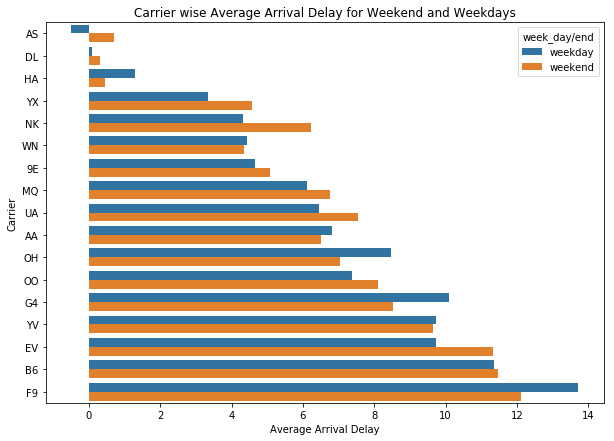

In [27]:
plt.figure(figsize=(10,7))
g=sns.barplot(x='avg_delay',y='carrier',hue='week_day/end',data=summary_1)
plt.title('Carrier wise Average Arrival Delay for Weekend and Weekdays')
g.set_ylabel('Carrier')
g.set_xlabel('Average Arrival Delay')

So, its evident from the above summary that the most difference we have got for any carrier for Avg Arrival Delay between weekends and weekdays is of 2 minutes, which is pretty small. So, the departure of flight on weekend or weekdays does'nt seem to make any difference in the delay.
however with the above chart we can deduce that for Airlines F9, B6, EV, YV the delays are significantly greater than the rest of the airlines.

2. Now, let's look at the Week of Month Variable.

In [ ]:
flight_delays.groupby(['week_of_month'])['arr_delay'].agg({'avg_delay':'mean'})

,avg_delay
week_of_month,
first_week,4.962301
last_week,4.509309
second_week,5.924157
third_week,7.243407


Seems like the flights in the 2nd or 3rd week of a month are more likely to be delayed, i checked this with Carrier wise group operation and got the same result. So, it seems like this variable is important in terms of deciding the arrival delay.

3. Let's look at the month variable and see the Scheduling of a flight in different months has any effect on average delay.

In [ ]:
flight_delays.groupby(['dep_flight_times'])[['arr_delay','time_gate_takeoff']].agg({'arr_delay':['mean','count'],
                                                                                'time_gate_takeoff':'mean'})

arr_delay          time_gate_takeoff
                       mean    count              mean
dep_flight_times                                      
Evening Time      10.220984  3184752         30.262797
Late/Odd Time     -1.627143  1796889         32.282101
Morning Time       2.904672  3926381         30.306036
Night Time        10.439240  1770247         61.513094

In [ ]:
flight_delays.groupby(['arr_flight_times'])[['arr_delay','time_land_gate']].agg({'arr_delay':['mean','count'],
                                                                                'time_land_gate':'mean'})

arr_delay          time_land_gate
                       mean    count           mean
arr_flight_times                                   
Evening Time       7.125022  3215551      12.748497
Late/Odd Time      1.588151   850990      47.961876
Morning Time       0.500307  3697623      12.857209
Night Time        11.461518  2914105      31.407213

In [ ]:
flight_delays.columns

Index(['year', 'quarter', 'month', 'carrier', 'route', 'origin', 'dest',
       'd_city', 'd_state', 'dep_delay', 'dep_delay_group', 'arr_delay',
       'arr_delay_group', 'cancelled', 'distance', 'num_passengers',
       'net_income', 'op_revenue', 'dep_flight_times', 'arr_flight_times',
       'week_day/end', 'week_of_month', 'air_delay', 'time_land_gate',
       'time_gate_takeoff', 'o_city', 'o_state'],
      dtype='object')

It is quite evident from above analysis that the flights arriving and departing at evening time or night time; which are from 2 PM to 11 PM at night, are delayed the most. As, we saw that most of the flights leave either in the morning or the evening time, which means that most arrivals would be happening around morning, evening and night time. Which is the case where arrival delay is highest around night and evening time. During the evening time, arrivals and departure are both high, and maybe due to this traffic the flights are delayed. Now, you might question that why isn't there a delay during morning timewhile we have the most flights arriving at morning time (I still need to figure that out and will discover it then. 

# Checking Arrival and Departure Delay distribution among Destination and Origin States:
To do that we are going to check whether there are difference in Average delay (Both Departure and Arrival) w.r.t origin and destination states.

Text(0, 0.5, 'Average Departure Delay')

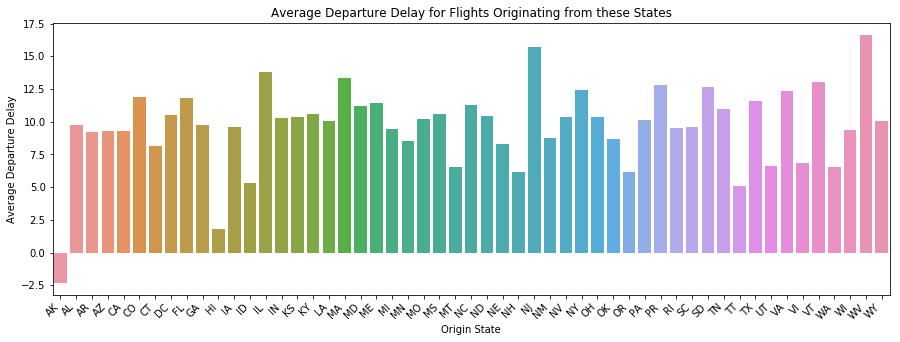

In [30]:
# Dest state:
summary_1=flight_delays.groupby(['o_state'])['dep_delay'].agg({'avg_dep_delay':'mean'}).reset_index()
plt.figure(figsize=(15,5))
g=sns.barplot(x='o_state',y='avg_dep_delay',data=summary_1)
# labels=chart.get_xticklabels()
plt.xticks(rotation=45, horizontalalignment='right')
plt.title('Average Departure Delay for Flights Originating from these States')
g.set_xlabel('Origin State')
g.set_ylabel('Average Departure Delay')

Text(0, 0.5, 'Average Arrival Delay')

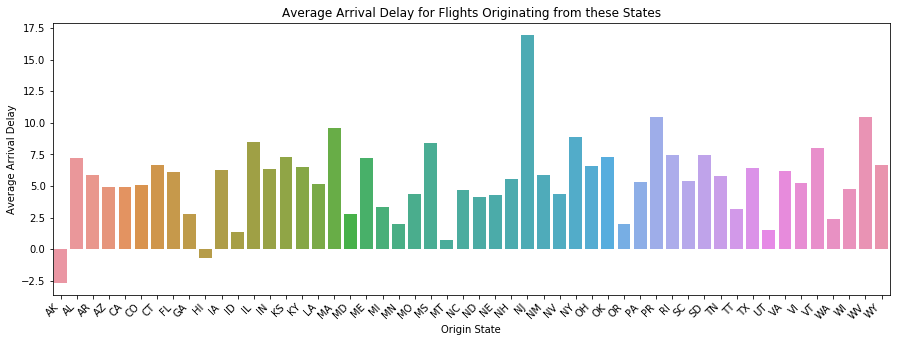

In [31]:
# Destination State:
summary_2=flight_delays.groupby(['d_state'])['arr_delay'].agg({'avg_arr_delay':'mean'}).reset_index()
plt.figure(figsize=(15,5))
g=sns.barplot(x='d_state',y='avg_arr_delay',data=summary_2)
plt.xticks(rotation=45, horizontalalignment='right')
plt.title('Average Arrival Delay for Flights Originating from these States')
g.set_xlabel('Origin State')
g.set_ylabel('Average Arrival Delay')

Looking at Departure and Arrival Delay together:
---

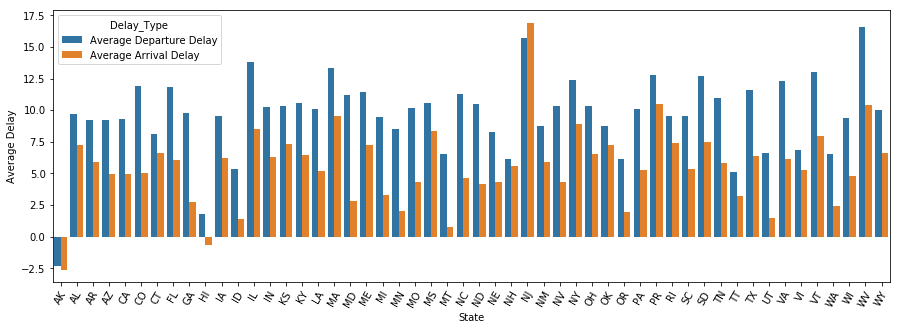

In [37]:
summary_states=summary_1.merge(summary_2,left_on=['o_state'],right_on=['d_state'],how='inner').drop('d_state',axis=1)
summary_states=pd.melt(summary_states,id_vars=['o_state'],value_vars=['avg_dep_delay','avg_arr_delay'],var_name='Delay_Type',value_name='Avg_Delay')
summary_states.columns=['State','Delay_Type','Avg_Delay']
plt.figure(figsize=(15,5))
g=sns.barplot(x='State',y='Avg_Delay',hue='Delay_Type',data=summary_states)
plt.xticks(rotation=60)
g.set_xlabel('State')
g.set_ylabel('Average Delay')
leg = g.axes.get_legend()
new_labels = ['Average Departure Delay', 'Average Arrival Delay']
for t, l in zip(leg.texts, new_labels): t.set_text(l)

In [ ]:
summary_1.merge(summary_2,left_on=['o_state'],right_on=['d_state'],how='inner').drop('d_state',axis=1).corr(method='pearson')

,avg_dep_delay,avg_arr_delay
avg_dep_delay,1.000000,0.812196
avg_arr_delay,0.812196,1.000000


For MD, OR, UT, MT, HI and GA has high departure delay and the corresponding Arrival Delay is less. Otherwise for every other state there is a strong positive correlation between Departure Delay and arrival Delay. This can be caused due to numerous factors,:
1. Weather
2. Busyness of the corrsponding Airport in the state
3. State Size and Its Popularity in terms of Business and Tourism, this is related to the Busyness of the airports in the state
E.g. the states like Virginia, New Jersey, Illinois, Massacheussets and Texas all are big states in terms of business capital etc, so they have high avg delays for both arrival and departure. Whereas, states like Arkansas, Idaho etc have small delays relatively. So, the state of variable for both destination and origin of any route is important for prediction.

Departure and Arrival Delays w.r.t Carriers:
---

In [39]:
q3=flight_delays[['arr_delay','dep_delay']].quantile(0.75,axis=0)
q1=flight_delays[['arr_delay','dep_delay']].quantile(0.25,axis=0)
up_range=q3+1.5*(q3-q1)
low_range=q1-1.5*(q3-q1)

Text(0, 0.5, 'Arrival Delay')

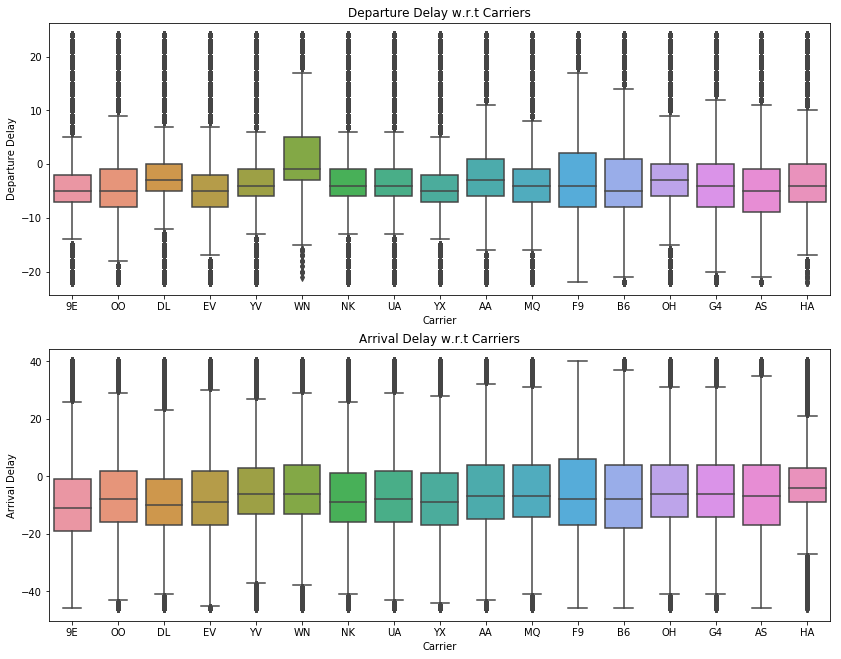

In [49]:
%matplotlib inline
q3=flight_delays[['arr_delay','dep_delay']].quantile(0.75,axis=0)
q1=flight_delays[['arr_delay','dep_delay']].quantile(0.25,axis=0)
up_range=q3+1.5*(q3-q1)
low_range=q1-1.5*(q3-q1)

datu_summary_dep=flight_delays.loc[(flight_delays['dep_delay']<up_range[1]) & (flight_delays['dep_delay']>low_range[1]),:]
datu_summary_arr=flight_delays.loc[(flight_delays['arr_delay']<up_range[0]) & (flight_delays['arr_delay']>low_range[0]),:]

plt.figure(figsize=(14,11))
plt.subplot(2,1,1)
g1=sns.boxplot(x='carrier',y='dep_delay',data=datu_summary_dep)
g1.set_title('Departure Delay w.r.t Carriers')
g1.set_xlabel('Carrier')
g1.set_ylabel('Departure Delay')

plt.subplot(2,1,2)
g2=sns.boxplot(x='carrier',y='arr_delay',data=datu_summary_arr)
g2.set_title('Arrival Delay w.r.t Carriers')
g2.set_xlabel('Carrier')
g2.set_ylabel('Arrival Delay')


Let's look at the average delays:
---

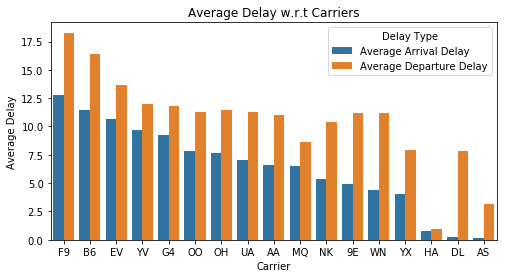

In [52]:
summary=flight_delays.groupby(['carrier'])['arr_delay','dep_delay'].agg("mean").reset_index().sort_values('arr_delay',ascending=False)
summary=pd.melt(summary,id_vars=['carrier'],value_vars=['arr_delay','dep_delay'],var_name='delay_type',value_name='avg_delay')
plt.figure(figsize=(8,4))
g=sns.barplot(x='carrier',y='avg_delay', hue='delay_type',data=summary)
g.set_title('Average Delay w.r.t Carriers')
g.set_xlabel('Carrier')
g.set_ylabel('Average Delay')
leg = g.axes.get_legend()
leg.set_title('Delay Type')

new_labels = ['Average Arrival Delay', 'Average Departure Delay']
for t, l in zip(leg.texts, new_labels): t.set_text(l)

Above summary provides information regarding the average departure and arrival delays w.r.t the Carrier. We can clearly see the about 70% of the carriers are those where arrival and departure delay have a positive correlation as they have large values for both type of delays.
Whereas a surprising thing is that for the carrier of DL, AS, NK, WN the departure delay is pretty large whereas the arrival delay is minute in comparison to the departure delay. Let's dig a bit deepr into this.

I would start the analysis by looking at the origin and destination for these flights that is the most frequent for these 4 carriers.

In [54]:
carriers=['DL','AS','NK','WN']
summary=flight_delays.loc[flight_delays['carrier'].isin(carriers),:].groupby(['carrier','o_state'])['o_state'].agg({'flights_from_origin':'count'}).reset_index()

states=summary.sort_values(['carrier','flights_from_origin'],ascending=False).groupby(['carrier']).head(1).set_index(['carrier','o_state']).reset_index()['o_state']
summary.sort_values(['carrier','flights_from_origin'],ascending=False).groupby(['carrier']).head(1).set_index(['carrier','o_state'])


,,flights_from_origin
carrier,o_state,
WN,CA,363749
NK,FL,65150
DL,GA,380541
AS,CA,101825


In [ ]:
summary=flight_delays.loc[flight_delays['carrier'].isin(carriers),:].groupby(['carrier','d_state'])['d_state'].agg({'flights_to_dest':'count'}).reset_index()

summary.sort_values(['carrier','flights_to_dest'],ascending=False).groupby(['carrier']).head(1).set_index(['carrier','d_state'])

C:\Users\Muhammad Hussain\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


,,flights_to_dest
carrier,d_state,
WN,CA,371904
NK,FL,65764
DL,GA,382100
AS,CA,103371


To compare the above results, let's see how the average departure and arrival delay are distributed for these states in the above analysis.

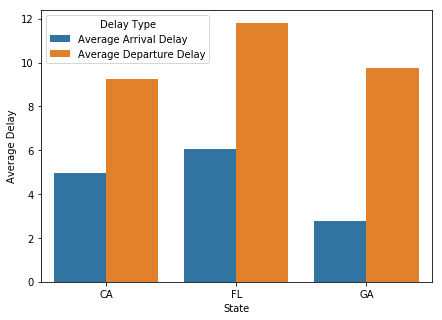

In [73]:
x1=flight_delays.groupby('d_state')['arr_delay'].agg({'avg_arr_delay':'mean'}).reset_index()
x2=flight_delays.groupby('o_state')['dep_delay'].agg({'avg_dep_delay':'mean'}).reset_index()
x1.columns=['State','avg_arr_delay']
x2.columns=['State','avg_dep_delay']

summary_states=x1.merge(x2,on='State')
summary_states.loc[summary_states['State'].isin(states),:]
data=summary_states.loc[summary_states['State'].isin(states),:]
data=pd.melt(data,id_vars=['State'],value_vars=['avg_arr_delay','avg_dep_delay'],value_name='Avg_Delay',var_name='Delay_Type')

plt.figure(figsize=(7,5))
g= sns.barplot(x='State',y='Avg_Delay',hue='Delay_Type',data=data)

g.set_xlabel('State')
g.set_ylabel('Average Delay')
plt.legend(loc='upper left')
leg = g.axes.get_legend()
leg.set_title('Delay Type')

new_labels = ['Average Arrival Delay', 'Average Departure Delay']
for t, l in zip(leg.texts, new_labels): t.set_text(l)

Thus, it seems like the Carriers DL, AS, NK, WN who has the highest difference in Departure and Arrival Delay has the most flights operated from these 3 states outlined above above (CA, FL, GA). When i tried looking at the average departure and arrival delay w.r.t these 3 states i found the same behavior, which is the abnormally high difference between the arrival and departure delay.

So, it seems to me that origin and destination state is an important variable in modeling the delays. But as we have about 6684 unique routes which are based on travel between airports in different states, so instead of using two categorical features of Origin and Destination States, we can use just the Routes Feature as this would also contain the effect of State Variables because Routes are decided on Airports, Origin and Destination States.  

Looking to see if size of Carrier (Num Passengers it carries on average), its Financial Stature (Revenue and Income) has something to do with delays:
---

In [ ]:
summary=flight_delays.groupby(['carrier'])['num_passengers','num_employees','net_income','op_revenue','arr_delay'].agg('mean').reset_index().corr()
summary.iloc[4,:]

num_passengers   -0.612895
num_employees    -0.272064
net_income       -0.400670
op_revenue       -0.395028
arr_delay         1.000000
Name: arr_delay, dtype: float64

In [ ]:
flight_delays.groupby(['carrier','year'])['num_passengers','num_employees','net_income','op_revenue','arr_delay'].agg('mean')

num_passengers  num_employees     net_income    op_revenue  \
carrier year                                                                 
9E      2018.0     4014.628576    4520.689444     -58.257424  6.777076e+02   
        2019.0     4446.090125    4561.015037    -175.036233  2.173688e+03   
AA      2018.0    23268.530942  108235.374425  327957.960236  4.718503e+06   
        2019.0    23569.687294  107378.773560  354389.320074  4.988195e+06   
AS      2018.0    19124.103051   17596.949769  138440.971365  2.003187e+06   
        2019.0    18147.475503   17601.004359  141553.665680  2.005744e+06   
B6      2018.0    12591.604522   20893.851006   65282.142451  7.139808e+05   
        2019.0    12888.982779   21504.969356   96236.577219  1.563347e+06   
DL      2018.0    24322.768032   88644.887274  541721.357289  7.924858e+06   
        2019.0    25267.591904   90025.979850  658685.108938  8.370675e+06   
EV      2018.0     3071.421371    3636.244552      29.480316  5.351630e+03   
        2019.0     2588.231749    2751.968501   15596.919509  1.474623e+04   
F9      2018.0     4787.696628    4002.878641   31221.312926  3.836345e+05   
        2019.0     4767.037528    4511.667175   44682.808807  5.500876e+05   
G4      2018.0     2332.761579    4046.258456   47756.809420  3.994046e+05   
        2019.0     2695.614093    4092.779381   84830.930220  4.500050e+05   
HA      2018.0    44779.563901    7088.610041   63717.743151  4.321023e+05   
        2019.0    42580.207083    7299.055450   54088.491336  5.054917e+05   
MQ      2018.0     4134.905133   14922.715648    -217.504423  6.968720e+03   
        2019.0     4064.395926   16015.797087    8804.336225  3.323960e+05   
NK      2018.0     7942.497268    7352.599150   44798.170744  6.111351e+05   
        2019.0     8240.706784    7946.680428   76707.295618  8.263095e+05   
OH      2018.0     5710.626015    3825.787065      53.293171  2.609144e+02   
        2019.0     5768.549150    4184.286278    6603.370675  2.035202e+05   
OO      2018.0     4433.147532   15302.317059   58343.980937  6.583074e+05   
        2019.0     4328.479720   16861.896086   45311.588740  7.094545e+05   
UA      2018.0    22094.017791   88515.025190  395115.867214  6.432481e+06   
        2019.0    21816.467005   89867.086617  437066.015713  6.513840e+06   
WN      2018.0    15863.823455   59014.798397  602991.782284  5.358671e+06   
        2019.0    15680.966647   60613.224931  551553.649608  5.373360e+06   
YV      2018.0     5305.821742    3322.281006   13289.417558  9.433044e+04   
        2019.0     4944.696822    3519.403598   10497.316005  1.650387e+05   
YX      2018.0     5661.142299    5854.201808   13445.859329  2.374045e+05   
        2019.0     5037.572113    6113.238880   18417.326848  3.212593e+05   

                arr_delay  
carrier year               
9E      2018.0   4.658430  
        2019.0   5.408237  
AA      2018.0   5.450770  
        2019.0   9.003290  
AS      2018.0  -0.501335  
        2019.0   1.541319  
B6      2018.0  11.432516  
        2019.0  11.396351  
DL      2018.0  -0.307333  
        2019.0   1.262195  
EV      2018.0   8.800700  
        2019.0  16.429955  
F9      2018.0  14.213311  
        2019.0  10.146858  
G4      2018.0  10.001162  
        2019.0   7.920306  
HA      2018.0   0.746902  
        2019.0   0.966587  
MQ      2018.0   5.357280  
        2019.0   8.631919  
NK      2018.0   5.171453  
        2019.0   5.754062  
OH      2018.0   8.237351  
        2019.0   6.492045  
OO      2018.0   7.044141  
        2019.0   9.291782  
UA      2018.0   5.819221  
        2019.0   9.735209  
WN      2018.0   4.500014  
        2019.0   4.130126  
YV      2018.0   8.853066  
        2019.0  11.311218  
YX      2018.0   3.076687  
        2019.0   6.040039

The result above shows the correlation of the 4 variables of "number of passengers","number of employees", "net income of the carrier","operating revenue of the carrier" with the Average Arrival Delay w.r.t the carrier.
Onething that i could decipher from the above result is that The Bigger the airline Carrier both w.r.t size (Number of Passengers and Employees) and financial perspective, have lesser delay, means that bigger airlines have better service and have less delay in their flights.
A Caveat:
---
So, all these variables explained above that explains the size of an airline are correlated to each other, and are giving the same information about the Arrival Delay, so i would just use one variable in the final prediction model to avoid the hazard of "Collinearity between variables".
And i would use "Number of Passengers" in the final prediction model as it has a very strong negative correlation with the arrival delay.

# Important Variables for the Prediction Task:
We have found some of the important variables that could be used in predicting the average flight delays. So, these variables are:
-  1. Departure Delay 2. Year 3. Quarter 4. Month 5. *Carrier* 6. *Route/Flight_Number* 7. Flight Departure Time (Categorical Variable) 8. Number of Passenegrs 9. Flight Arrival Time (Categorical Variable) 10. Week of Month 11. Origin State 12. Destination State 13. Number of Passengers
- Starred Variables are the grouping variables, because prediction would be made w.r.t to these variables.

Now, there are a few caveats. We found these variables to be important for average arrival delay, but here the prediction is to be made w.r.t each Flight and Carrier. So, we cannot just use some of the above explained variables in there crude form, we have to transform them and create another dataset from the original Flight Delays dataset, so that we can feed it to the model and generate predictions for our task.
- Thus, strategy here id to first predict the average delays w.r.t each flight number and then grouping all the predicted arrival delays w.r.t each flight with the carrier those flights fall in, and calculating the average flight delays w.r.t each carrier.

Let me re-iterate the task here:
The task is to design a model that would predict the average arrival delay w.r.t Airline and Flight/Route for the 3rd Quarter of 2019.
So, i have written a few lines on how to transform each of these important variables below.
Variables Transformation:
---
- Departure Delay: As shown that the departure delay is a very important predictor with strong correlation with the Arrival Delay. I explained this fact above through visualizations that there are differences in Departure Delay w.r.t each Carrier and state. Thus, we can use this for our prediction model. Now the Question arises, how can we use it. I would use "Avg Departure Delay for States" and "Carrriers". "Also, Avg Departure delay for each route." (3 Variables)
- Arrival Delay: As we did for the Departure Delay, same would be done for Arrival Delay, and 3 variables for Route, Carrier and State would be created.
- Flight Departure Time: I would create a variable using this Flight Departure Time such that, one would be w.r.t each Flight Num: For each flight number what is time it departs the most at.
- Number of Passengers: It's been shown above that larger the size of passengers associated with a carrier or in other words (bigger the carrier) the better service it provides with smaller arrival delay, so this variable would be used.
- Flight Arrival Time: I would create a variable using this Flight Arrival Time such that, one would be w.r.t each Flight Num: For each flight number what is time it Arrives the most at.
- Week of Month: Week of month is a deciding factor as well, as we saw earlier that flights in second and third week are delayed the most.
- Destination and Origin State: Destination and Origin States have an important role in deciding the delay as we looked certain states like CA and GA has abnormally high number for average delays. But if we just consider the route variable, i think these two variables can be taken into account with just the route variable, as route takes into account the origin and destination state.
- Number of Passengers: Number of Passenegrs of the carrier in each year

In [ ]:
flight_delays.head()

,year,quarter,month,carrier,flight_num,route,origin,dest,d_city,d_state,...,op_revenue,dep_flight_times,arr_flight_times,week_day/end,week_of_month,air_delay,time_land_gate,time_gate_takeoff,o_city,o_state
0,2018.0,1.0,1.0,9E,3331.0,42.0,ABY,ATL,"Atlanta, GA",GA,...,674.25,Late/Odd Time,Morning Time,weekend,first_week,-8.0,6.0,51.0,Albany,GA
1,2018.0,1.0,1.0,9E,3940.0,42.0,ABY,ATL,"Atlanta, GA",GA,...,674.25,Evening Time,Evening Time,weekend,first_week,-11.0,46.0,11.0,Albany,GA
2,2018.0,1.0,1.0,9E,3409.0,42.0,ABY,ATL,"Atlanta, GA",GA,...,674.25,Late/Odd Time,Late/Odd Time,weekend,first_week,-1.0,9.0,13.0,Albany,GA
3,2018.0,1.0,1.0,9E,3940.0,42.0,ABY,ATL,"Atlanta, GA",GA,...,674.25,Evening Time,Evening Time,weekend,first_week,-14.0,6.0,11.0,Albany,GA
4,2018.0,1.0,1.0,9E,3353.0,42.0,ABY,ATL,"Atlanta, GA",GA,...,674.25,Late/Odd Time,Late/Odd Time,weekend,first_week,-4.0,11.0,11.0,Albany,GA


In [ ]:
data_1=flight_delays.groupby(['carrier','route','year','quarter','month','week_of_month'])['dep_delay','arr_delay'].agg('mean').reset_index()

In [ ]:
data_1.shape

(645516, 8)

In [ ]:
k=flight_delays.groupby(['carrier','route','year','quarter','month','week_of_month','dep_flight_times'])['dep_flight_times'].agg({'counts':'count'})
k=k.reset_index().sort_values(['carrier','route','year','quarter','month','week_of_month','counts'],ascending=[True,True,True,True,True,True,False])
data_2=k.groupby(['carrier','route','year','quarter','month','week_of_month']).head(1).drop('counts',axis=1)

In [ ]:
k=flight_delays.groupby(['carrier','route','year','quarter','month','week_of_month','arr_flight_times'])['arr_flight_times'].agg({'counts':'count'})
k=k.reset_index().sort_values(['carrier','route','year','quarter','month','week_of_month','counts'],ascending=[True,True,True,True,True,True,False])
data_3=k.groupby(['carrier','route','year','quarter','month','week_of_month']).head(1).drop('counts',axis=1)

In [ ]:
main_dataframe=data_1.merge(data_2,on=['carrier','route','year','quarter','month','week_of_month'],how='inner')
main_dataframe=main_dataframe.merge(data_3,on=['carrier','route','year','quarter','month','week_of_month'],how='inner')

In [ ]:
del(data_1)
del(data_2)
del(data_3)

In [4]:
# Saving the dataframe for prediction model:
path_file='C:\\Users\\Muhammad Hussain\\Desktop\\CompetitionData'
file_path=os.path.join(path_file,'competition_final_dataframe_newest.xlsx')
# main_dataframe.to_excel(file_path)
main_dataframe=pd.read_excel(file_path)

In [ ]:
colab_path='/content/gdrive/My Drive'
file_path=os.path.join(colab_path,'competition_final_dataframe_newest.xlsx')
main_dataframe=pd.read_excel(file_path)

In [5]:
main_dataframe=main_dataframe.drop('Unnamed: 0',axis=1)


# Trends of average delay with month and year:
Let's look at the trend of delays for each carrier w.r.t each month (for first six months) and year. This would give us an idea of how the Arrival Delays have changed over the months and the two years of 2018 and 2019.


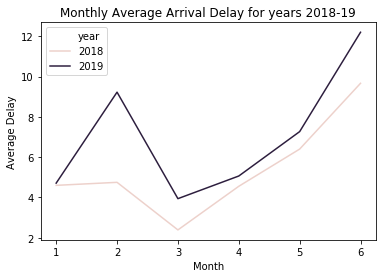

In [78]:
plotu=main_dataframe.groupby(['year','month'])['arr_delay'].agg({'avg_delay':'mean'}).reset_index()
plotu=plotu.loc[plotu['month']<=6,:]
plotu=plotu.astype({'year':'int'})
import seaborn as sns
g=sns.lineplot(x='month',y='avg_delay',hue='year',data=plotu)

g.set_title('Monthly Average Arrival Delay for years 2018-19')
g.set_xlabel('Month')
g.set_ylabel('Average Delay')
plt.legend(loc='upper left')

C:\Users\Muhammad Hussain\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


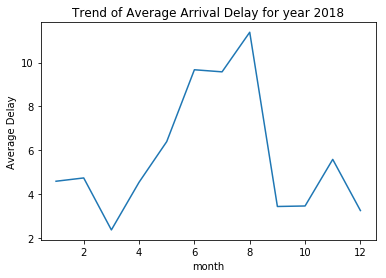

In [ ]:
plotu=main_dataframe.groupby(['year','month'])['arr_delay'].agg({'avg_delay':'mean'}).reset_index()
plotu=plotu.loc[plotu['year']==2018,:]
fig=sns.lineplot(x='month',y='avg_delay',data=plotu)
fig.set(xlabel='month', ylabel='Average Delay', title='Trend of Average Arrival Delay for year 2018')
plt.show()

In [ ]:
del(plotu)

[Text(0, 0.5, 'Average Arrival Delay 2018'),
 Text(0.5, 0, 'Average Arrival Delay 2018'),
 Text(0.5, 1.0, 'Arrival Delay Comparison for first 6 months b/w 2018-19')]

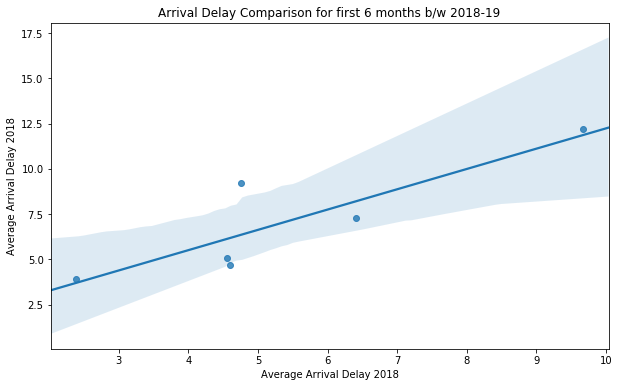

In [79]:
summary_1=main_dataframe.groupby(['year','month'])['arr_delay'].agg({'avg_delay':'mean'}).reset_index()

summary_1=summary_1.loc[summary_1['month']<=6,:]

summary_1=summary_1.pivot_table(index=['month'],columns=['year'],values=['avg_delay'])
summary_1.columns=['avg_delay_2018','avg_delay_2019']


plt.figure(figsize=(10,6))
g=sns.regplot(x='avg_delay_2018',y='avg_delay_2019',data=summary_1)
g.set(xlabel='Average Arrival Delay 2018',ylabel='Average Arrival Delay 2018',title='Arrival Delay Comparison for first 6 months b/w 2018-19')

In [ ]:
import statsmodels.api as sm

x=summary_1['avg_delay_2018']
y=summary_1['avg_delay_2019']

# Note the difference in argument order
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
predictions = model.predict(x) # make the predictions by the model

# Print out the statistics
model.summary()

C:\Users\Muhammad Hussain\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Muhammad Hussain\Anaconda3\lib\site-packages\statsmodels\stats\stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         avg_delay_2019   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     11.98
Date:                Mon, 04 May 2020   Prob (F-statistic):             0.0258
Time:                        11:21:18   Log-Likelihood:                -10.746
No. Observations:                   6   AIC:                             25.49
Df Residuals:                       4   BIC:                             25.08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.0218      1.892      0.540      0.618      -4.231       6.275
avg_delay_2018     1.1212      0.324      3.462      0.026       0.222       2.021
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.314
Prob(Omnibus):                    nan   Jarque-Bera (JB):                1.057
Skew:                           1.025   Prob(JB):                        0.590
Kurtosis:                       2.843   Cond. No.                         15.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
summary_1

,avg_delay_2018,avg_delay_2019
month,,
1.0,4.602744,5.172354
2.0,4.779588,9.475750
3.0,2.157435,3.749485
4.0,4.285847,5.308534
5.0,6.376595,7.233670
6.0,9.455899,12.069927


# Looking at the relationship of Departure Delay and Arrival Delay:

[Text(0, 0.5, 'Arrival Delay'),
 Text(0.5, 0, 'Departure Delay'),
 Text(0.5, 1.0, 'Relationship between Departure Delay and Arrival Delay')]

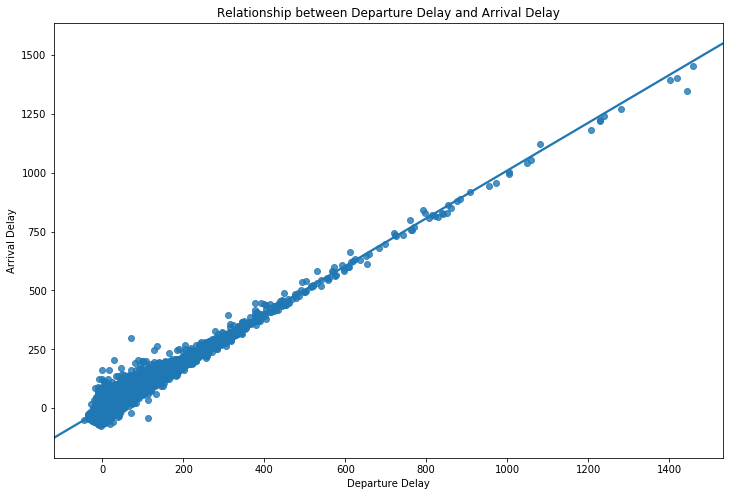

In [6]:
dd=main_dataframe[['dep_delay','arr_delay']]
plt.figure(figsize=(12,8))
g=sns.regplot(x='dep_delay',y='arr_delay',data=dd)
g.set(xlabel='Departure Delay',ylabel='Arrival Delay',title='Relationship between Departure Delay and Arrival Delay')

In [ ]:
X=main_dataframe[['dep_delay']]
y=main_dataframe[['arr_delay']]

In [ ]:
from sklearn.linear_model import LinearRegression
model=LinearRegression().fit(X,y)

In [ ]:
import statsmodels.api as sm

# Note the difference in argument order
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model


In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              arr_delay   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                 1.244e+08
Date:                Wed, 13 May 2020   Prob (F-statistic):               0.00
Time:                        21:41:48   Log-Likelihood:            -4.3107e+07
No. Observations:            10678269   AIC:                         8.621e+07
Df Residuals:                10678267   BIC:                         8.621e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.0133      0.004  -1165.623      0.000      -5.022      -5.005
dep_delay      1.0078   9.04e-05   1.12e+04      0.000       1.008       1.008
==============================================================================
Omnibus:                  5422332.046   Durbin-Watson:                   1.361
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        222369839.440
Skew:                           1.770   Prob(JB):                         0.00
Kurtosis:                      25.074   Cond. No.                         48.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

An adjusted R-Squared Value gives us an idea that Departure Delay explains about 92% of the variance in the Arrival Delay, so what if we can predict the Departure Delay for Q3 of 2019 using all the variables and then use this regression model to predict the arrival delays. We'll explore the strategy in the section below.

In [ ]:
filename = 'reg_model_model.sav'
colab_path=path
joblib.dump(model, os.path.join(colab_path,filename))

# Caveats:
- One thing to note here is that the Arrival Delay can be predicted using the variables of "Route, Carrier, etc" and specially the "Departure Delay". As, i just used a regression model to see the relationship between the independent variables and the "Arrival Delay".
- We are not given any data for Quarter 3 of 2019, as most of the variables of "Route, Carrier, Departure Time, Month, Week of Departure etc" are all categorical and we can use them for predicting the Arrival Delays for Q3 without any hassle as we have to use the same scenerios just for 3rd Quarter of 2019.
- The problem arises how are we going to get the values for "Departure Delay" for Q3, 2019 to be used with the rest of the categorical variables in order to Predict Arrival Delays. And as explained Arrival Delay highly depends on Departure Delay, so it's important to get the values of Departure Delay for Q3, 2019 first.

# Strategy For Predicting the Flight Delays by Flight and Routes for 3rd Quarter of 2019:
My strategy is that as in main_dataframe dataset, we have most of the variables as categorical. The only variables that are continuous are "Departure Delay" and "Arrival Delay". As, arrival delay is highly correlated (R=0.96 :"Strong Positive Correlation") with the Departure Delay as explained above. And Departure Delay is dependent upon the categorical variables in the data. So, my idea is to use all the categorical variables to predict the departure delays for 3rd Quarter of 2019 and then use that forecasted Departure Delay data to predict the corresponding arrival delay using simple model like regression.

# Modeling:

# Modeling the Categorical feature of "Route" as it has too many categories to be modeled as a dummy variable.


In [ ]:
main_dataframe.groupby('route')['route'].count()
main_dataframe.route.nunique()

6632

So, as we found that there are about 6632 unqie routes that are present in the dataset, previously there were 6684 routes, so the 52 routes were excluded for not having enough data for predicting the flight delays, thus we would consider these 6632 routes data. So, if i use one hot encoding for categorical variable encoding, the feature space is going to explode. So, i would say using the Binary Encoding Technique where number of feature from converting categorical variable using "Binary Encoding" we get Logbase2(number of unique categories), which makes 6632 categories in Categorical feature of "Route" to 13 encoded feature as compared to 6632 features using the "One Hot Encoding".

# Trying Binary Encoding for Route Variable and creating Training and Test Set:

In [ ]:
!pip install category_encoders

In [ ]:
import category_encoders as ce

In [ ]:
from sklearn.model_selection import train_test_split
dataset_catboost=main_dataframe.drop(['arr_delay','quarter'],axis=1)
dataset_catboost=dataset_catboost.astype({'route':'category','year':'category'})

route_var=dataset_catboost['route']
rest_data=dataset_catboost.drop('route',axis=1)
rest_data=pd.get_dummies(rest_data)
route_var=ce.BinaryEncoder().fit_transform(route_var)

dataset_catboost=pd.concat([rest_data,route_var],axis=1)

X=dataset_catboost.drop('dep_delay',axis=1)
y=dataset_catboost['dep_delay']

# Train_Test:
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.85)

# Train_Validation:
X_train_new,X_valid_new,y_train_new,y_valid_new=train_test_split(X_train,y_train,train_size=0.85)



# Algorithms:
I am going to focus here on Tree like algorithms, as we have most of the data in categorical form, and the dependent variable of "Departure Delay" is different among different scenerios of categorical variables.
Also, in this data we have categories which can have a hierarchial relationship with each other.
E.g we have a carrier "AA (American Airlines)" and it is being operated along several different routes and would have different delays among different routes. So, a tree like algorithm would first split on the basis of carrier and then further split on the basis of other variables like "Route" or "Departure Times" etc. So, with this intuition Tree algorithms feel the best fit for our task.
I would try 3 types algorithms from Decision Trees:
1. Random Forest
2. Gradient Boosting Trees
3. CatBoost Algorithm 

# Random Forest Regressor
Selecting Optimal Parameters using Cross Validation
---

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse

In [ ]:
n_estimators=[50,70,90,100,120,130,150,180,200]
max_features=[4,5,6,7,8,9,10,11,13,15,20]
dictu={}
combination=1
for estimators in n_estimators:
    for features in max_features:
        random_forest=RandomForestRegressor(n_estimators=estimators,max_features=features,random_state=5)
        random_forest.fit(X_train_new,y_train_new)
        predictions=random_forest.predict(X_valid_new)
        error=mse(predictions,y_valid_new)
        xp=str(estimators)+"-"+str(features)
        dictu[xp]=error
        combination+=1


In [ ]:
optimal_params=min(dictu.keys(), key=(lambda k: dictu[k]))

In [ ]:
n_estimator=int(optimal_params.split('-')[0])
max_features=int(optimal_params.split('-')[1])

In [ ]:
print(n_estimator)
print(max_features)

120
7


In [ ]:
random_forest=RandomForestRegressor(n_estimators=120,max_features=7,random_state=5)
random_forest.fit(X_train,y_train)
predictions=random_forest.predict(X_test)
error_rf=mse(predictions,y_test)

In [ ]:
print('Error from Random Forest is: '+str(round(error_rf,2)))

Error from Random Forest is: 567.99


# Gradient Boosting Machines
Selecting Optimal Parameters through Cross Validation
---

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
n_estimators=[120,130,150,200]
max_depths=[5,8,10,15]
learning_rates=[0.01,0.05,0.1]

dictu={}
combination=1
for n_estimator in n_estimators:
    for max_depth in max_depths:
        for learning_rate in learning_rates:
            print("Trying "+str(combination)+' Combination')
            booster=GradientBoostingRegressor(subsample=0.8,max_depth=max_depth,n_estimators=n_estimator,learning_rate=learning_rate)
            booster.fit(X_train_new,y_train_new)
            predictions=booster.predict(X_valid_new)
            error=mse(predictions,y_valid_new)
            key=str(n_estimator)+'-'+str(max_depth)+'-'+str(learning_rate)
            dictu[key]=error
            combination+=1


In [ ]:
k=min(dictu.keys(),key=(lambda k: dictu[k])).split('-')
n_estim=int(k[0])
max_dep=int(k[1])
lr=float(k[2])

In [12]:
booster=GradientBoostingRegressor(subsample=0.8,max_depth=15,n_estimators=200,learning_rate=0.1,
                                 criterion='friedman_mse',loss='lad',min_samples_leaf=30)
booster.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='lad',
                          max_depth=15, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=30, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=0.8, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
# booster=GradientBoostingRegressor(subsample=0.8,max_depth=max_dep,n_estimators=n_estim,learning_rate=lr)
booster=GradientBoostingRegressor(subsample=0.8,max_depth=15,n_estimators=200,learning_rate=0.1)
booster.fit(X_train,y_train)

In [ ]:
from sklearn.metrics import mean_squared_error as mse

In [ ]:
predictions=booster.predict(X_test)
error_booster=mse(predictions,y_test)

In [16]:
print('Error from GBM is: '+str(round(error_booster,2)))

Error from GBM is: 553.18


# CatBoost Algorithm:
Catboost Algorithm uses the same concept of gradient boosting on decision trees as applied above, but the one edge of using Catboost Algorithm instead of "Gradient Boosting" from Scikit-Learn is that the "CatBoost" can take categorical variables aswell. Thus, this can save us from the hassle of going through the process of transforming Categorical Variables into Numerical ones.
I won't go too deep into the details of how the Catboost use the transformation of Categorical Variables. for a reference i would say that the Catboost Algorithm uses Supervised methods of Transforming categorical variables by looking at the response variable and then using different buckets of distinct classes in which different labels of categorical variable would fall.
I had used "Binary Encoding" previously for Gradient Boosting Algorithm, here we can see how well the Catboost Performs on our dataset with its own categorical variable encoding techniques.


In [ ]:
dataset_catboost=main_dataframe.drop(['arr_delay','quarter'],axis=1)
dataset_catboost=dataset_catboost.astype({'route':'category','year':'category','month':'float64'})

In [ ]:
X=dataset_catboost.drop('dep_delay',axis=1)
y=dataset_catboost['dep_delay']

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.80)

In [ ]:
# Validation set data:
X_train_new,X_valid_new,y_train_new,y_valid_new=train_test_split(X_train,y_train,train_size=0.75)

In [ ]:
categorical_features_indices=np.where(X.dtypes != np.float)[0]

In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostRegressor
iterations=[100,120,150,200,250,300]
depth=[6,8,10,12,15]
erru={}
for i in iterations:
    for j in depth:
        model=CatBoostRegressor(iterations=i, depth=j, learning_rate=0.01, loss_function='Lq:q=2.2',
                       od_type='IncToDec',eval_metric='MAE',
                       od_pval=0.001,od_wait=5,use_best_model=True)
        model.fit(X_train_new, y_train_new,cat_features=categorical_features_indices,eval_set=(X_valid_new, y_valid_new),plot=True)
        preds=model.predict(X_valid_new)
        err=mse(preds,y_valid_new)
        erru[str(i)+'-'+str(j)]=err

In [ ]:
min(erru.keys(),key=(lambda k: erru[k]))

'300-15'

I have used the Lq loss function in this algorithm as this is like the Mean Squared Error Loss function where the only difference is that in this "Loss Function",we have the liberty to choose the power coefficient instead of using the squared error in the MSE Loss Function. So, i used about 2.2 as the power coefficient as i wanted the model to punish itself more for predictions that are way off. So, why i considered it is because as i show below that the "Departure Delay" is pretty volatile with a standard deviation of 23. So, i want the model to catch different delay values correctly through differnt configurations of our feature space.

In [ ]:
model4=CatBoostRegressor(iterations=300, depth=15, learning_rate=0.01, loss_function='Lq:q=2.2',min_data_in_leaf=60)
model4.fit(X_train,y_train,cat_features=categorical_features_indices)

In [52]:
predictions=model4.predict(X_test)
error=mse(predictions,y_test)
print('Test Error is: '+str(round(error,2)))

Test Error is: 491.51


# Result:
The CatBoost Method has given us the smallest Test MSE of 491.51. So, i would use the boosting algorithm for predicting the Departure Delays for Q3, 2019 and then we can use that to predict the Arrival Delays for Q3, 2019.

# Predictions:

# Creating the Test Dataset for 3rd Quarter Predictions:

In [ ]:
dataset=main_dataframe.drop(['arr_delay','dep_delay'],axis=1)
new_dat=dataset.drop_duplicates()
new_dat=new_dat.reset_index()
year=[]
for i in range(len(new_dat)):
    if new_dat['quarter'][i]==3:
        year.append(2019)
    else:
        year.append(2018)
new_dat['year']=year
new_dat=new_dat.loc[new_dat['quarter']==3,:].drop('index',axis=1).drop_duplicates()
new_dat=new_dat.astype({'route':'category','year':'category','month':'float64'})
pred_dat=new_dat.drop('quarter',axis=1)

CatBoost Prediction:
---

In [ ]:
dep_delay_q3=model4.predict(pred_dat)
new_dat['dep_delay_q3']=dep_delay_q3

In [ ]:
predicted_dataset=new_dat

In [ ]:
predicted_dataset.to_excel(os.path.join(colab_path,'Predicted_Dataset.xlsx'))

In [62]:
predicted_dataset.head()

,carrier,route,year,quarter,month,week_of_month,dep_flight_times,arr_flight_times,dep_delay_q3
14,9E,1,2019,3,8.0,last_week,Late/Odd Time,Morning Time,9.678354
15,9E,1,2019,3,8.0,third_week,Late/Odd Time,Morning Time,10.254446
16,9E,1,2019,3,9.0,first_week,Evening Time,Evening Time,8.015141
17,9E,1,2019,3,9.0,last_week,Evening Time,Evening Time,8.802708
18,9E,1,2019,3,9.0,second_week,Evening Time,Evening Time,9.315090


In [ ]:
q3_dataset=pd.read_excel(os.path.join(colab_path,'Predicted_Dataset.xlsx'))
q3_dataset=q3_dataset.drop('Unnamed: 0',axis=1)

In [69]:
q3_dataset.head()

,carrier,route,year,quarter,month,week_of_month,dep_flight_times,arr_flight_times,dep_delay_q3
0,9E,1,2019,3,8,last_week,Late/Odd Time,Morning Time,9.678354
1,9E,1,2019,3,8,third_week,Late/Odd Time,Morning Time,10.254446
2,9E,1,2019,3,9,first_week,Evening Time,Evening Time,8.015141
3,9E,1,2019,3,9,last_week,Evening Time,Evening Time,8.802708
4,9E,1,2019,3,9,second_week,Evening Time,Evening Time,9.315090


Using the Regression Model we trained earlier to predict the Arrival Delay for Q3 using the dataset for Q3 we created.
---

In [27]:
deps=q3_dataset[['dep_delay_q3']]

(109252, 1)

In [ ]:
arr_Delay_q3=model.predict(deps)

In [ ]:
q3_dataset['arrival_delay_q3']=arr_Delay_q3

In [35]:
q3_dataset.head(5)

,carrier,route,year,quarter,month,week_of_month,dep_flight_times,arr_flight_times,dep_delay_q3,arrival_delay_q3
0,9E,1,2019,3,8,last_week,Late/Odd Time,Morning Time,9.678354,4.766236
1,9E,1,2019,3,8,third_week,Late/Odd Time,Morning Time,10.254446,5.350440
2,9E,1,2019,3,9,first_week,Evening Time,Evening Time,8.015141,3.079606
3,9E,1,2019,3,9,last_week,Evening Time,Evening Time,8.802708,3.878262
4,9E,1,2019,3,9,second_week,Evening Time,Evening Time,9.315090,4.397858


In [ ]:
q3_dataset.to_excel(os.path.join(colab_path,'Final_Predicted_Dataset_newest.xlsx'))

Let's look at the Trend of Arrival Delay over the months in 3rd Quarter:
---

In [82]:
path=os.getcwd()

In [83]:
q3_dataset=pd.read_excel(os.path.join(path,'Final_Predicted_Dataset_newest.xlsx'))


In [86]:
q3_dataset=q3_dataset.drop('Unnamed: 0',axis=1)


In [ ]:
dataset_2019=q3_dataset[['year','month','arrival_delay_q3']]
dataset_2018=main_dataframe.loc[main_dataframe['quarter']==3,['year','month','arr_delay']]
dataset_2019=dataset_2019.rename(columns={'arrival_delay_q3':'arr_delay'})

In [ ]:
datu=pd.concat([dataset_2019,dataset_2018],axis=0)


In [ ]:
result=datu.groupby(['year','month'])['arr_delay'].agg({'mean'}).reset_index()

In the plot below i just tried to show the Monthly Average Arrival Delay for 3rd Quarter in 2018 for reference so that we can compare these with our predictions for Arrival Delay aggregated over the months in 3rd quarter of 2019.

Text(0, 0.5, 'Average Arrival Delay')

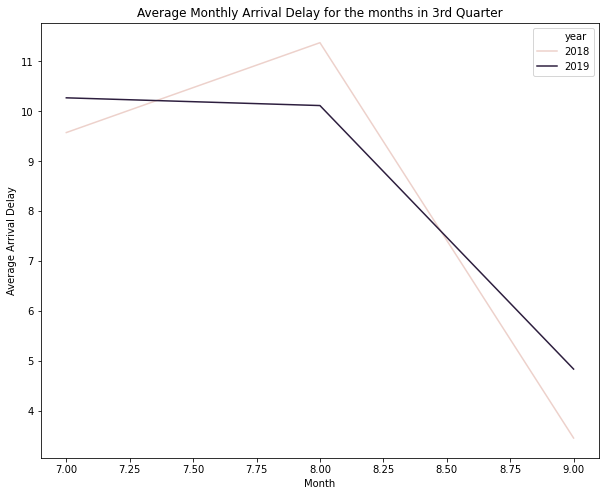

In [58]:
plt.figure(figsize=(10,8))
g=sns.lineplot(x='month',y='mean',hue='year',data=result)
plt.title('Average Monthly Arrival Delay for the months in 3rd Quarter')
g.set_xlabel('Month')
g.set_ylabel('Average Arrival Delay')
plt.show()

In [87]:
q3_dataset.head()

,carrier,route,year,quarter,month,week_of_month,dep_flight_times,arr_flight_times,dep_delay_q3,arrival_delay_q3
0,9E,1,2019,3,8,last_week,Late/Odd Time,Morning Time,9.678354,4.766236
1,9E,1,2019,3,8,third_week,Late/Odd Time,Morning Time,10.254446,5.350440
2,9E,1,2019,3,9,first_week,Evening Time,Evening Time,8.015141,3.079606
3,9E,1,2019,3,9,last_week,Evening Time,Evening Time,8.802708,3.878262
4,9E,1,2019,3,9,second_week,Evening Time,Evening Time,9.315090,4.397858


File "Predicted Dataset" loaded as q3_dataset here contains all the predictions to the very granular level, where the predicted arrival delay is available for each Carrier and the Route for specified month, week of month, departure time and the arrival time of the flight.

You can read the first line such that for a flight from carrier "9E", flying on the route "1", in the last week of month of "August", sometime Late at night (i.e after 12:00 AM) and reaching at the destination aometime in the Morning, would have a predicted arrival delay of 4.7 Minutes.

Arrival Delay w.r.t Carrier:
---

In [90]:
Carrier_Predicted_Delay=q3_dataset.groupby('carrier')['arrival_delay_q3'].agg({'Averge Arrival Delay':'mean'})
print(Carrier_Predicted_Delay)

         Averge Arrival Delay
carrier                      
9E                   9.049937
AA                   9.902548
AS                  -0.427958
B6                  12.826210
DL                   4.606234
EV                  14.132746
F9                  13.971295
G4                   7.804996
HA                   2.193851
MQ                   8.327221
NK                   8.698569
OH                  10.742237
OO                   7.998950
UA                  10.119288
WN                   7.704059
YV                  10.934402
YX                   5.106613


In [95]:
Carrier_Predicted_Delay.to_excel(os.path.join(path,'Carrier_Predicted_Delays.xlsx'))

Arrival Delay w.r.t Route:
---

In [94]:
Route_Predicted_Delay=q3_dataset.groupby('route')['arrival_delay_q3'].agg({'Averge Arrival Delay':'mean'})
Route_Predicted_Delay.to_excel(os.path.join(path,'Route_Predicted_Delays.xlsx'))